# Combine gene-anatomy expression resources (Bgee and TISSUES)

In [1]:
import sys
import gzip

import pandas

# local imports
sys.path.insert(0, '../')
import utils

%matplotlib inline

## Read TISSUES

In [2]:
commit = 'd6b0c99352db27469f2c3399cecb6f9fae2db547'
url = utils.rawgit('dhimmel', 'tissues', commit, 'data/merged.tsv.gz')
tissues_df = pandas.read_table(url, compression='gzip')
tissues_df = tissues_df.fillna(0)

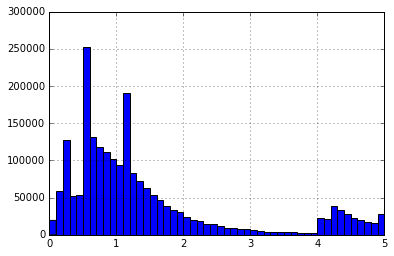

In [3]:
# Histogram of integrated scores
tissues_df.score_integrated.hist(bins=50);

In [4]:
cutoff = 2
tissues_df = tissues_df[(tissues_df.score_experiment_unbiased >= cutoff) | (tissues_df.score_integrated >= cutoff)]
tissues_df['unbiased'] = (tissues_df.score_experiment_unbiased >= cutoff).astype(int)

In [5]:
tissues_df.unbiased.value_counts()

1    244315
0    209679
Name: unbiased, dtype: int64

In [6]:
len(tissues_df)

453994

In [7]:
tissues_df.head()

,uberon_id,uberon_name,entrez_gene_id,gene_symbol,score_text,score_knowledge,score_experiment,score_experiment_unbiased,score_integrated,unbiased
26,UBERON:0000002,uterine cervix,60,ACTB,1.6,0,4,4,4.9,1
60,UBERON:0000002,uterine cervix,142,PARP1,2.2,0,0,0,2.2,0
84,UBERON:0000002,uterine cervix,207,AKT1,2.1,0,0,0,2.6,0
90,UBERON:0000002,uterine cervix,218,ALDH3A1,0.6,4,0,0,4.2,0
96,UBERON:0000002,uterine cervix,226,ALDOA,0.0,4,4,4,4.8,1


In [8]:
tissues_df = tissues_df[['uberon_id', 'entrez_gene_id', 'unbiased']]
tissues_df['source'] = 'TISSUES'
tissues_df.head()

,uberon_id,entrez_gene_id,unbiased,source
26,UBERON:0000002,60,1,TISSUES
60,UBERON:0000002,142,0,TISSUES
84,UBERON:0000002,207,0,TISSUES
90,UBERON:0000002,218,0,TISSUES
96,UBERON:0000002,226,1,TISSUES


## Read Bgee

In [9]:
commit = '08ba54e83ee8e28dec22b4351d29e23f1d034d30'
url = utils.rawgit('dhimmel', 'bgee', commit, 'data/present-in-adult.tsv.gz')
bgee_df = pandas.read_table(url, compression='gzip')
bgee_df.head(2)

,entrez_gene_id,CL:0000015,CL:0000019,CL:0000023,CL:0000115,CL:0000169,CL:0000738,CL:0000842,CL:0002092,CL:0002328,...,UBERON:0008188,UBERON:0009834,UBERON:0009835,UBERON:0010414,UBERON:0011876,UBERON:0013540,UBERON:0013541,UBERON:0013554,UBERON:0014892,UBERON:0016525
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,1,0,1,0,1,1,...,1,1,1,1,1,1,0,1,1,0


In [10]:
bgee_df = pandas.melt(bgee_df, id_vars='entrez_gene_id', var_name='uberon_id', value_name='present')
bgee_df = bgee_df.query('present == 1')
bgee_df['unbiased'] = 1
bgee_df = bgee_df.rename(columns={'GeneID': 'entrez_gene_id'})
bgee_df = bgee_df[['uberon_id', 'entrez_gene_id', 'unbiased']]
bgee_df['source'] = 'Bgee'
bgee_df.head()

,uberon_id,entrez_gene_id,unbiased,source
1,CL:0000015,2,1,Bgee
8,CL:0000015,16,1,Bgee
14,CL:0000015,23,1,Bgee
27,CL:0000015,37,1,Bgee
28,CL:0000015,38,1,Bgee


In [11]:
len(bgee_df)

1150688

## Concatenate Bgee and TISSUES

In [12]:
def condense(df):
    """Consolidate relationships into a unique anatomy-gene observations."""
    row = pandas.Series()
    sources = set(df['source'])
    row['sources'] = '|'.join(sorted(sources))
    row['unbiased'] = df.unbiased.max()
    if sources == {'TISSUES'}:
        row['license'] = 'CC BY 4.0'
    else:
        row['license'] = None
    return row

concat_df = pandas.concat([tissues_df, bgee_df])
concat_df = concat_df.groupby(['uberon_id', 'entrez_gene_id']).apply(condense).reset_index()

In [13]:
concat_df.unbiased.value_counts()

1    1353158
0     178467
Name: unbiased, dtype: int64

In [14]:
with gzip.open('AeG-expression.tsv.gz', 'wt') as write_file:
    concat_df.to_csv(write_file, sep='\t', index=False)